In [166]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from operator import itemgetter
import pickle

In [158]:
#Reading data into a dataframe object
data = pd.read_csv('train-missings.csv')
#Handling missing valuses using linear interpolation
data = data.interpolate()
data = data.fillna(0)


In [141]:
Y = data.values[:,-1]
set(Y)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}

Based on Y values, we can assume it is probably a classification problem.

To find out which features are not much effective in estimating the 'target' labels, We train several Logistic Regressions, removing one feature each time. We keep deleting useles features until we reach a point that we achieve a better accuracy without deleting any feature.

In [145]:
repeat = True
useless_features = []
#Repeat untill we acheive a better accuracy without deleteing any feature
while repeat:
    
    models = []
    for i in range(0,14):
        
        cols = list(range(1,14))
        for f in useless_features:
            cols.remove(f)
        # if i==0 means we don't wanna delete any feature.
        if i > 0 and i in cols:
            cols.remove(i)
            
        X = data.values[:,cols]
        Y = data.values[:,-1]
        
        #scalling columns
        min_max_scaler = preprocessing.MinMaxScaler()
        X = min_max_scaler.fit_transform(X)
        
        #Splitting data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
        models.append((clf, clf.score(X_test,y_test)))
        
    best_model = max(models,key=itemgetter(1))
    if models.index(best_model) > 0:  
        print("score is highest without feature p{}".format(models.index(best_model)))
        print(best_model[1])
        useless_features.append(models.index(best_model))
    else:
        print("useless features are {}".format(useless_features))
        repeat = False

score is highest without feature p5
0.6084656084656085
useless features are [5]


In [148]:
cols = list(range(1,14))
for f in useless_features:
    cols.remove(f)
X = data.values[:,cols]
Y = data.values[:,-1]
#scalling columns
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

model = best_model[0]
model.score(X_test, y_test)

0.628968253968254

In [167]:
#Train new model on whole data
cols = list(range(1,14))
for f in useless_features:
    cols.remove(f)
X = data.values[:,cols]
Y = data.values[:,-1]
#scalling columns
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X, Y)
pickle.dump(clf, open('model', 'wb'))

In [ ]:
cols = list(range(1,14))
for f in useless_features:
    cols.remove(f)
X = data.values[:,cols]

#scalling columns
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Y = data.values[:,-1]
lb = preprocessing.LabelBinarizer()
lb.fit(Y)
Y = lb.transform(Y)

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

neural_net = keras.models.Sequential()

neural_net.add(keras.layers.Dense(10, activation='sigmoid', input_shape=(X_train.shape[1],)))
#neural_net.add(keras.layers.Dense(10, activation='sigmoid'))
neural_net.add(keras.layers.Dense(7, activation='sigmoid'))
neural_net.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='categorical_crossentropy' , metrics=['accuracy'])
neural_net.fit(X_train, y_train,epochs=30)

neural_net.evaluate(X_test,y_test)

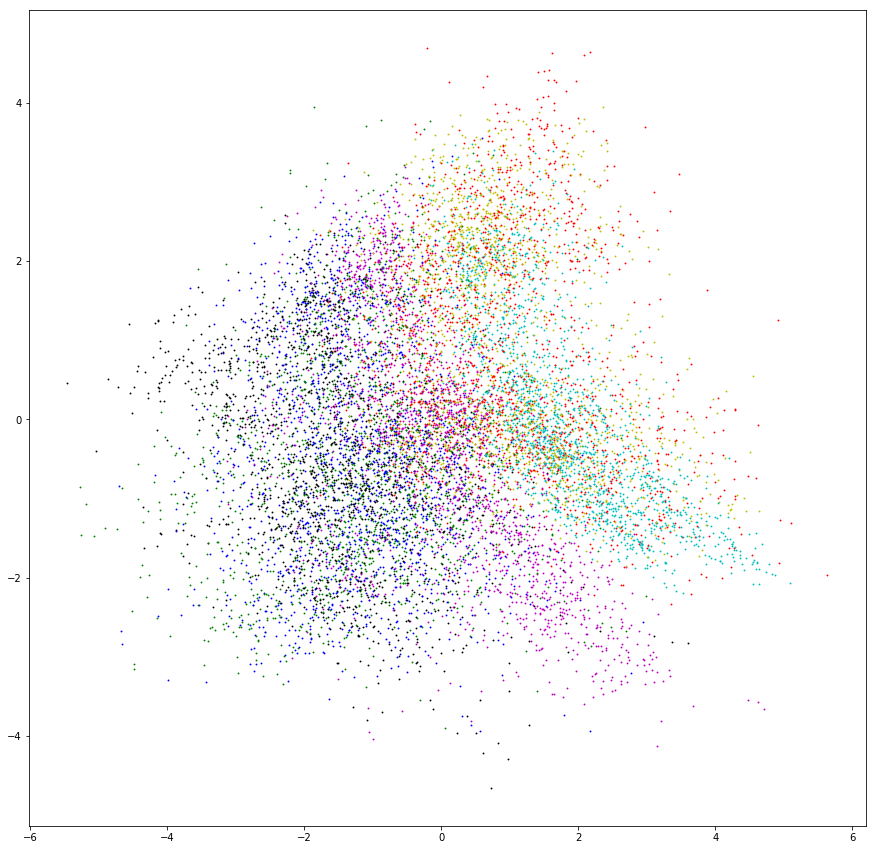

In [164]:
#Visulizing data
colors = ['b','g','r','c','m','y','k']
def _draw(data,targets):
    figsize = (15,15)
    data = StandardScaler().fit_transform(data)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, pd.Series(data=targets,name='name')], axis = 1)
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)
    for i, target in enumerate(targets):
        ax.scatter(x = finalDf['principal component 1'][i] ,
                       y = finalDf['principal component 2'][i],c=colors[int(target)-1], s=0.75)
    plt.show()
_draw(X_train,y_train)